##### setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [68]:
def plot_corr_bar(df):
    corr = df.drop(columns=['Attrition']).corrwith(df['Attrition']).sort_values(ascending=False)
    corr = corr[corr.abs() > .075]
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(8, 6))
    sns.barplot(x=corr.values, y=corr.index, palette='viridis')
    plt.title('Feature Correlation with Attrition')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
def undersample(df, target_col='Attrition'):
    df_majority = df[df[target_col] == 0]
    df_minority = df[df[target_col] == 1]

    df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    return df_balanced.sample(frac=1, random_state=42)  # Shuffle the dataset

def boolify_ints(df):
    df = df.copy()
    for col in df.select_dtypes(include=['int']).columns:
        if col == 'Attrition':
            continue

        # skip trivially binary/constant columns
        if df[col].nunique() <= 2:
            continue

        threshold_high = df[col].quantile(0.75)
        threshold_low = df[col].quantile(0.25)

        # If quartiles are identical (e.g., very discrete or constant), skip to avoid empty classes
        if threshold_high == threshold_low:
            continue

        # Use inclusive checks so values equal to the quartile are captured
        df[f'{col}_high'] = (df[col] >= threshold_high).astype(int)
        df[f'{col}_low'] = (df[col] <= threshold_low).astype(int)

        # drop original int column
        df.drop(columns=[col], inplace=True)
    return df

def plot_increased_odds_ratio(df, target_col='Attrition', threshold=1.5, distance_from_one=None, p_value_threshold=None, figsize=(10, 8)):
    odds_ratios = {}
    p_values = {}
    
    for col in df.columns:
        if col == target_col:
            continue
        contingency_table = pd.crosstab(df[col], df[target_col])
        if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
            continue
        
        # Calculate odds ratio
        odds_ratio = (contingency_table.iloc[1,1] * contingency_table.iloc[0,0]) / (contingency_table.iloc[1,0] * contingency_table.iloc[0,1] + 1e-10)
        odds_ratios[col] = odds_ratio
        
        # Calculate p-value using chi-square test
        chi2, p_val, dof, expected = chi2_contingency(contingency_table)
        p_values[col] = p_val

    # Filter by odds ratio threshold (keep both increased and decreased odds)
    filtered_odds_ratios = odds_ratios.copy()
    
    # Filter by absolute distance from 1 if specified
    if distance_from_one is not None:
        filtered_odds_ratios = {k: v for k, v in filtered_odds_ratios.items() if abs(v - 1) > distance_from_one}
    
    # Filter by p-value if specified
    if p_value_threshold is not None:
        filtered_odds_ratios = {k: v for k, v in filtered_odds_ratios.items() if p_values[k] < p_value_threshold}
    
    sorted_odds_ratios = dict(sorted(filtered_odds_ratios.items(), key=lambda item: item[1], reverse=True))

    import matplotlib.pyplot as plt


    fig, ax = plt.subplots(figsize=figsize)
    keys = list(sorted_odds_ratios.keys())
    vals = list(sorted_odds_ratios.values())

    sns.barplot(x=vals, y=keys, palette='magma', ax=ax)

    title_parts = []
    if distance_from_one is not None:
        title_parts.append(f'Absolute distance from 1 > {distance_from_one}')
    if p_value_threshold is not None:
        title_parts.append(f'p-value < {p_value_threshold}')

    if title_parts:
        ax.set_title('Features with ' + ', '.join(title_parts))
    else:
        ax.set_title('All Features Odds Ratios')
    ax.set_xlabel('Odds Ratio')
    ax.set_ylabel('Features')

    # Annotate each bar with its odds ratio value
    max_val = max(abs(v) for v in vals) if vals else 0
    x_offset = max_val * 0.01 if max_val != 0 else 0.01
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + x_offset, p.get_y() + p.get_height() / 2, f"{width:.2f}", va='center')

    plt.tight_layout()
    plt.show()
    
    return sorted_odds_ratios

def get_data():
    df = pd.read_csv('../data/ind_turnover.csv')
    df = df.drop(columns=['EmployeeCount'])
    df['Education'] = df['Education'].astype('category')
    df['JobLevel'] = df['JobLevel'].astype('category')
    df['PerformanceRating'] = df['PerformanceRating'].astype('category')

    df['Attrition'] = (df['Attrition'] == 'Yes').astype(int)
    df = pd.get_dummies(df, drop_first=False)
    df.set_index('EmployeeNumber', inplace=True)
    df_balanced = undersample(df, target_col='Attrition')
    df_bool = boolify_ints(df)
    df_balanced_bool = boolify_ints(df_balanced)

    drop_cols = [
        'Gender_Male',
        'OverTime_No',
        'MaritalStatus_Single',
        'Over18_Y',
        'StandardHours'
    ]
    df_bool = df_bool.drop(columns=drop_cols)
    df_balanced_bool = df_balanced_bool.drop(columns=drop_cols)
    return df_bool, df_balanced_bool

In [3]:
df_bool, df_balanced_bool = get_data()

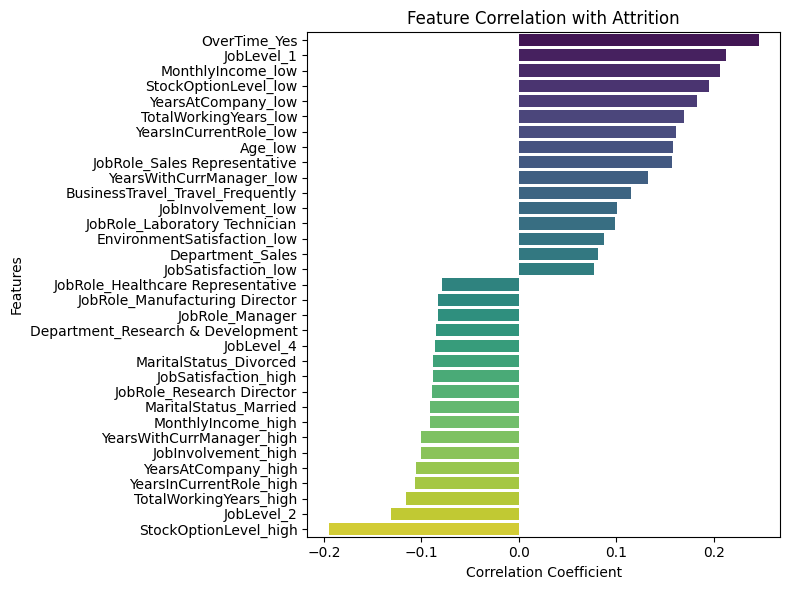

In [4]:
plot_corr_bar(df_bool)
# plot_corr_bar(df_balanced_bool)

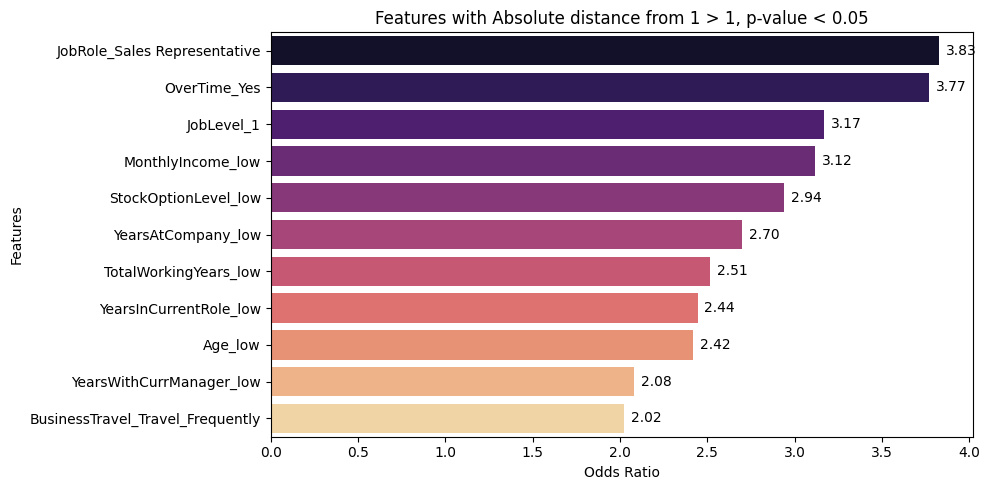

In [73]:
odds_ratios = plot_increased_odds_ratio(df_bool, target_col='Attrition', distance_from_one=1, p_value_threshold=0.05, figsize=(10,5))

# model

In [6]:
def fit_cat_boost_model(df, target_col='Attrition', cv_folds=5):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Compute class weights
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weight_dict = dict(zip(classes, class_weights))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Base model with overfitting prevention and class weights
    base_model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=4,
        l2_leaf_reg=3,
        random_strength=1,
        bagging_temperature=1,
        class_weights=class_weight_dict,
        verbose=False,
        random_state=42
    )
    
    # Cross-validation
    cv_scores = cross_val_score(base_model, X_train, y_train, cv=cv_folds, scoring='accuracy')
    print(f'Cross-validation scores: {cv_scores}')
    print(f'Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})')
    
    # Small parameter tuning
    param_grid = {
        'depth': [3, 4, 5],
        'learning_rate': [0.03, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5]
    }
    
    grid_search = GridSearchCV(
        CatBoostClassifier(iterations=300, class_weights=class_weight_dict, verbose=False, random_state=42),
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best CV score: {grid_search.best_score_:.4f}')
    
    # Train final model with best parameters
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {test_accuracy:.4f}')
    
    return best_model

In [7]:
model = fit_cat_boost_model(df_balanced_bool, target_col='Attrition', cv_folds=5)

Cross-validation scores: [0.67105263 0.75       0.73684211 0.67105263 0.76      ]
Mean CV accuracy: 0.7178 (+/- 0.0777)
Best parameters: {'depth': 5, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
Best CV score: 0.7441
Test accuracy: 0.6842


In [8]:
imbalanced_model = fit_cat_boost_model(df_bool, target_col='Attrition', cv_folds=5)

Cross-validation scores: [0.8559322  0.82978723 0.85106383 0.82553191 0.81702128]
Mean CV accuracy: 0.8359 (+/- 0.0301)
Best parameters: {'depth': 5, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
Best CV score: 0.8622
Test accuracy: 0.8639


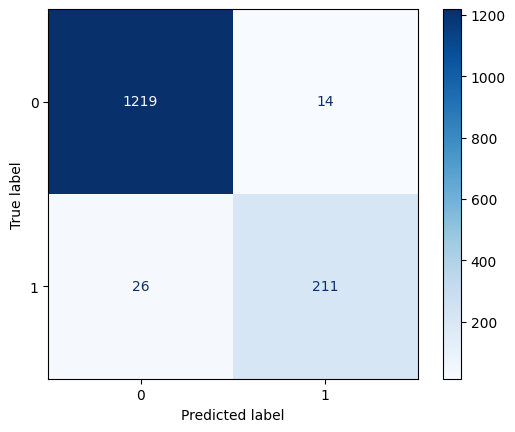

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = imbalanced_model.predict(df_bool.drop(columns=['Attrition']))
ConfusionMatrixDisplay.from_predictions(df_bool['Attrition'], y_pred, cmap='Blues')
plt.show()

# Shap

In [10]:
def get_shap_values(model, df, target_col='Attrition'):
    import shap

    X = df.drop(columns=[target_col])
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    shap.summary_plot(shap_values, X)
    return shap_values

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


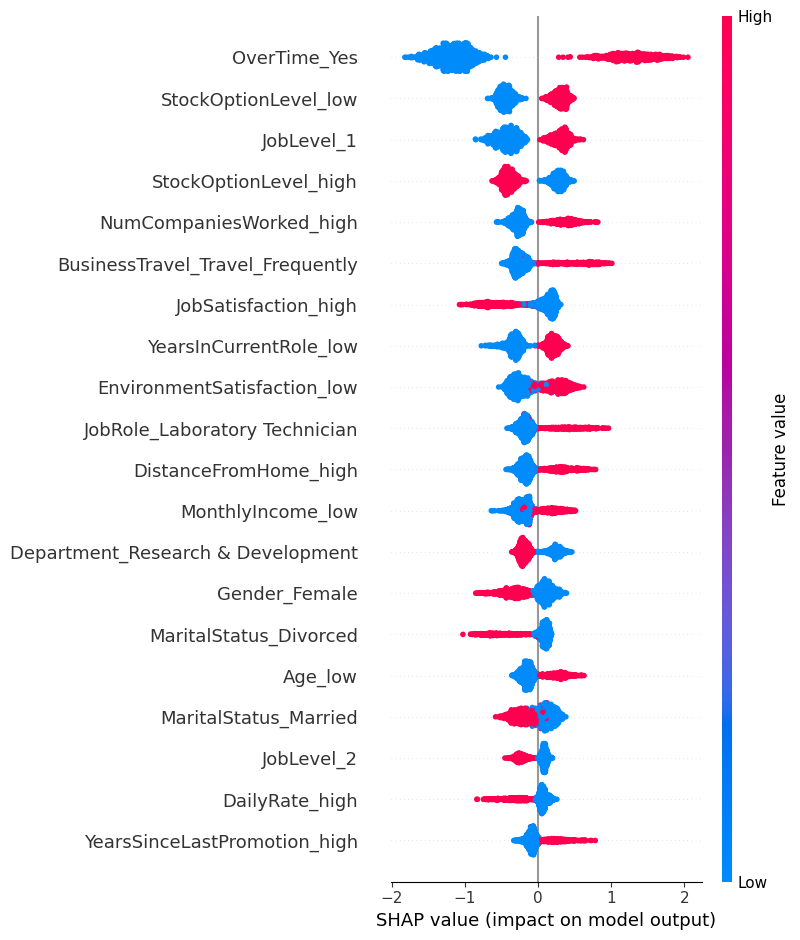

In [11]:
shap_values = get_shap_values(imbalanced_model, df_bool)

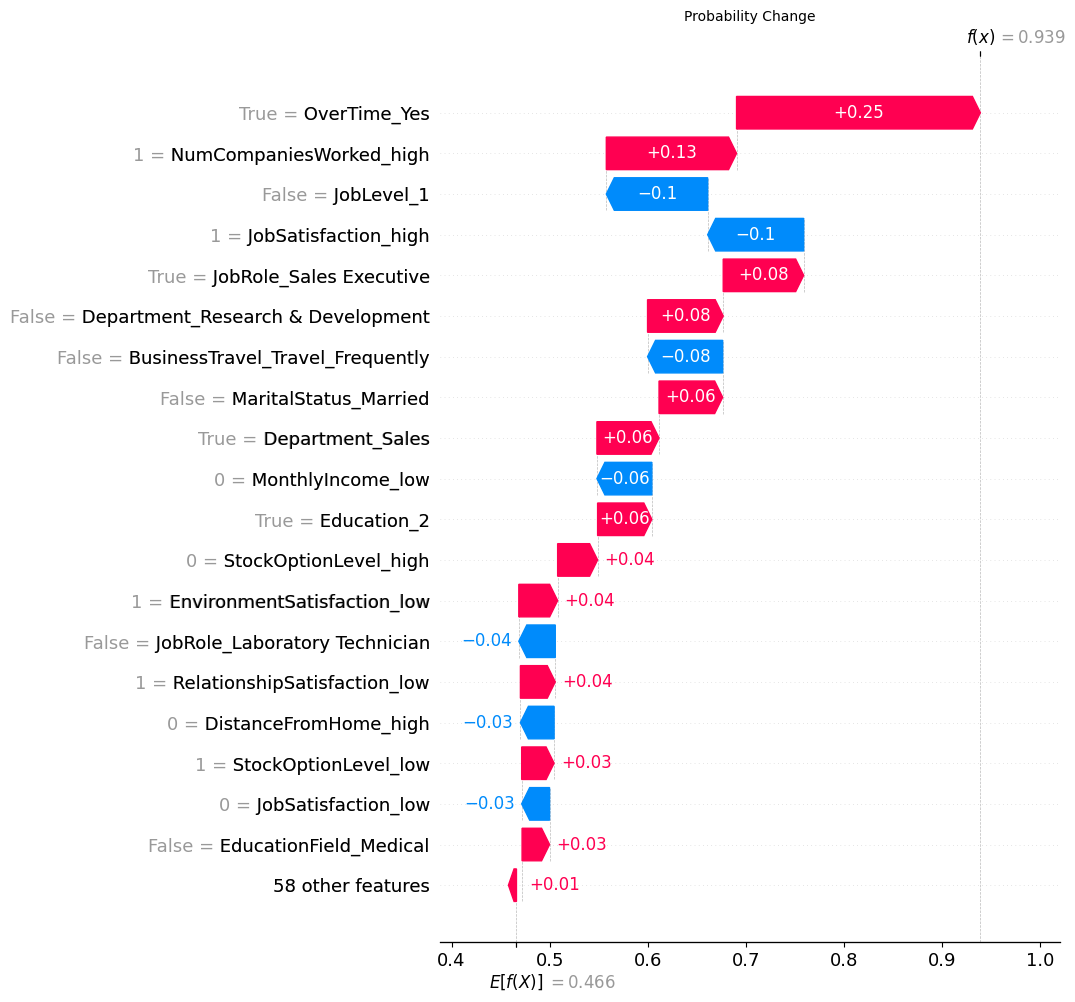

Base probability: 0.466
Final probability: 0.939


In [29]:
# Plot waterfall with probability changes
import shap

# Convert log odds to probabilities
def logit_to_prob(logit):
    return 1 / (1 + np.exp(-logit))

# Get base probability and prediction probability for first sample
base_logit = shap_values.base_values[0]
prediction_logit = base_logit + shap_values.values[0].sum()

base_prob = logit_to_prob(base_logit)
prediction_prob = logit_to_prob(prediction_logit)

# Convert SHAP values to probability contributions
prob_contributions = []
cumulative_logit = base_logit

for shap_val in shap_values.values[0]:
    old_prob = logit_to_prob(cumulative_logit)
    cumulative_logit += shap_val
    new_prob = logit_to_prob(cumulative_logit)
    prob_contributions.append(new_prob - old_prob)

# Create a modified explanation object for waterfall plot
prob_shap_values = shap.Explanation(
    values=np.array(prob_contributions),
    base_values=base_prob,
    data=shap_values[0].data,
    feature_names=shap_values.feature_names
)

# Plot waterfall with probability changes
shap.waterfall_plot(prob_shap_values, max_display=20, show=False)
plt.gca().set_xlabel('Probability Change')
plt.show()

print(f"Base probability: {base_prob:.3f}")
print(f"Final probability: {prediction_prob:.3f}")


In [46]:
# Convert SHAP values to probability contributions for all samples
def convert_shap_to_prob_contributions(shap_values):
    prob_contributions_all = []
    
    for i in range(len(shap_values.values)):
        base_logit = shap_values.base_values[i]
        prob_contributions = []
        cumulative_logit = base_logit
        
        for shap_val in shap_values.values[i]:
            old_prob = logit_to_prob(cumulative_logit)
            cumulative_logit += shap_val
            new_prob = logit_to_prob(cumulative_logit)
            prob_contributions.append(new_prob - old_prob)
        
        prob_contributions_all.append(prob_contributions)
    
    return np.array(prob_contributions_all)

# Convert all SHAP values to probability contributions
prob_contributions_matrix = convert_shap_to_prob_contributions(shap_values)

# Take mean absolute probability contributions across all samples
mean_abs_prob_contributions = np.mean(np.abs(prob_contributions_matrix), axis=0)

# Create explanation object for bar plot
prob_shap_values_all = shap.Explanation(
    values=mean_abs_prob_contributions,
    feature_names=shap_values.feature_names
)


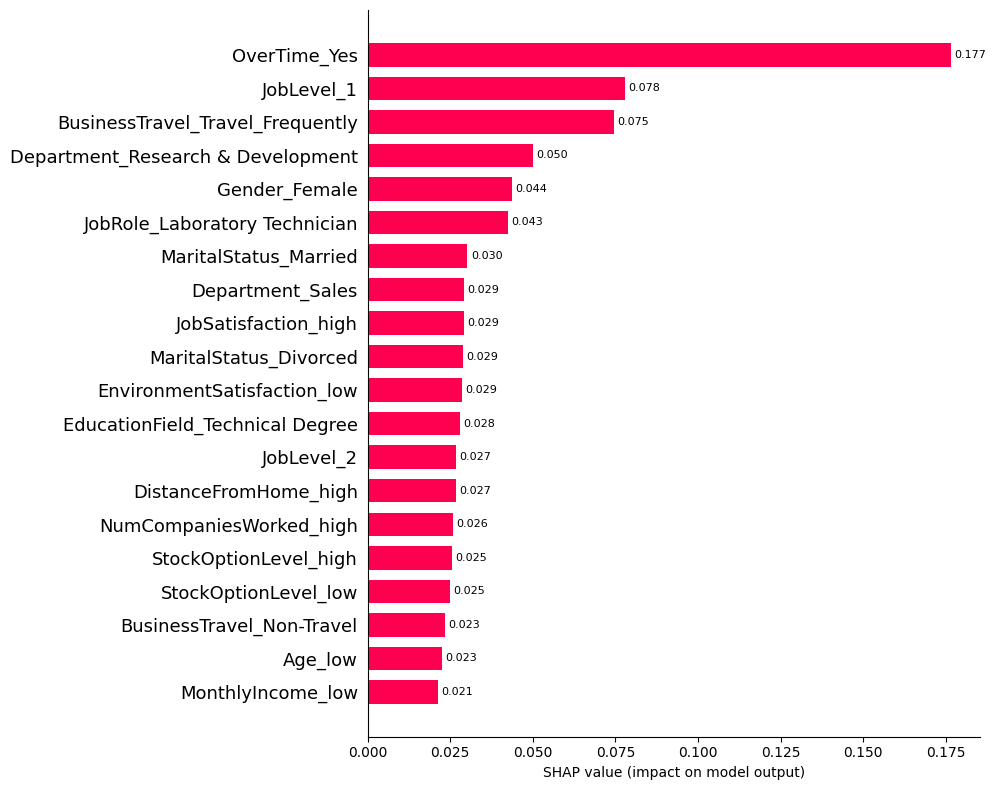

In [56]:
figsize = (10,  8)
plt.figure(figsize=figsize)
shap.bar_plot(prob_shap_values_all.values, feature_names=prob_shap_values_all.feature_names, max_display=20, show=False)

# Add value labels to the bars
ax = plt.gca()
for i, bar in enumerate(ax.patches):
    width = bar.get_width()
    ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

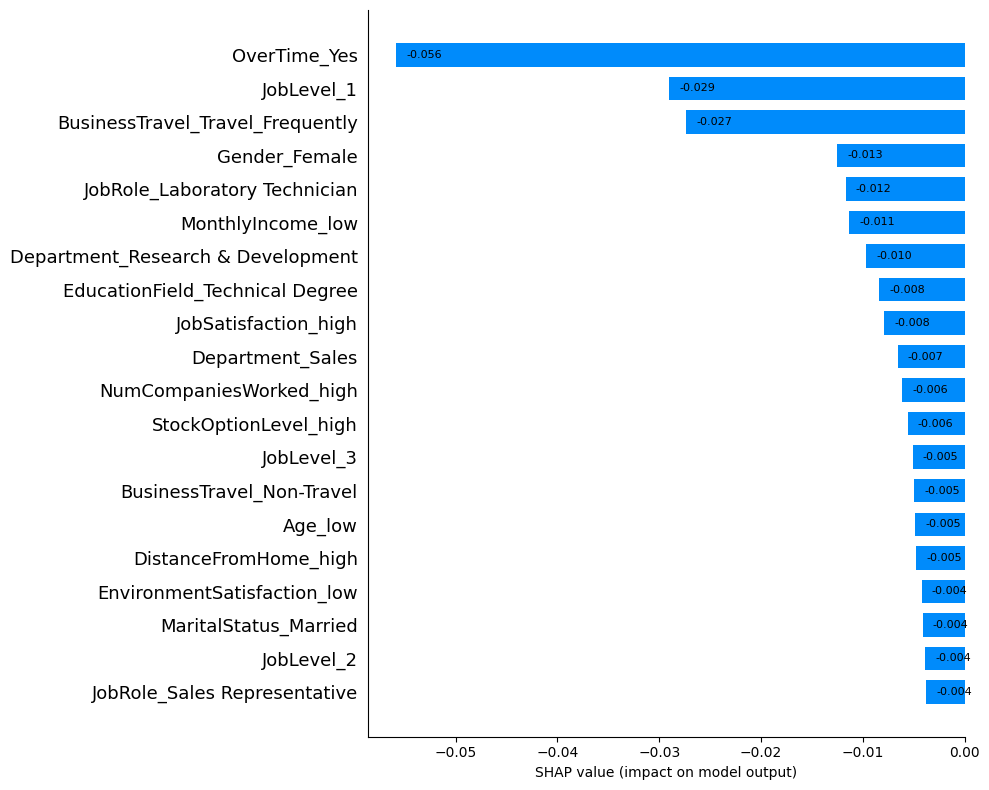

In [66]:
# Take mean probability contributions across all samples (without absolute value)
mean_prob_contributions = np.mean(prob_contributions_matrix, axis=0)

# Create explanation object for bar plot
prob_shap_values_all = shap.Explanation(
    values=mean_prob_contributions,
    feature_names=shap_values.feature_names
)

figsize = (10,8)
plt.figure(figsize=figsize)
shap.bar_plot(prob_shap_values_all.values, feature_names=prob_shap_values_all.feature_names, max_display=20, show=False)

# Add value labels to the bars
ax = plt.gca()
for i, bar in enumerate(ax.patches):
    width = bar.get_width()
    ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

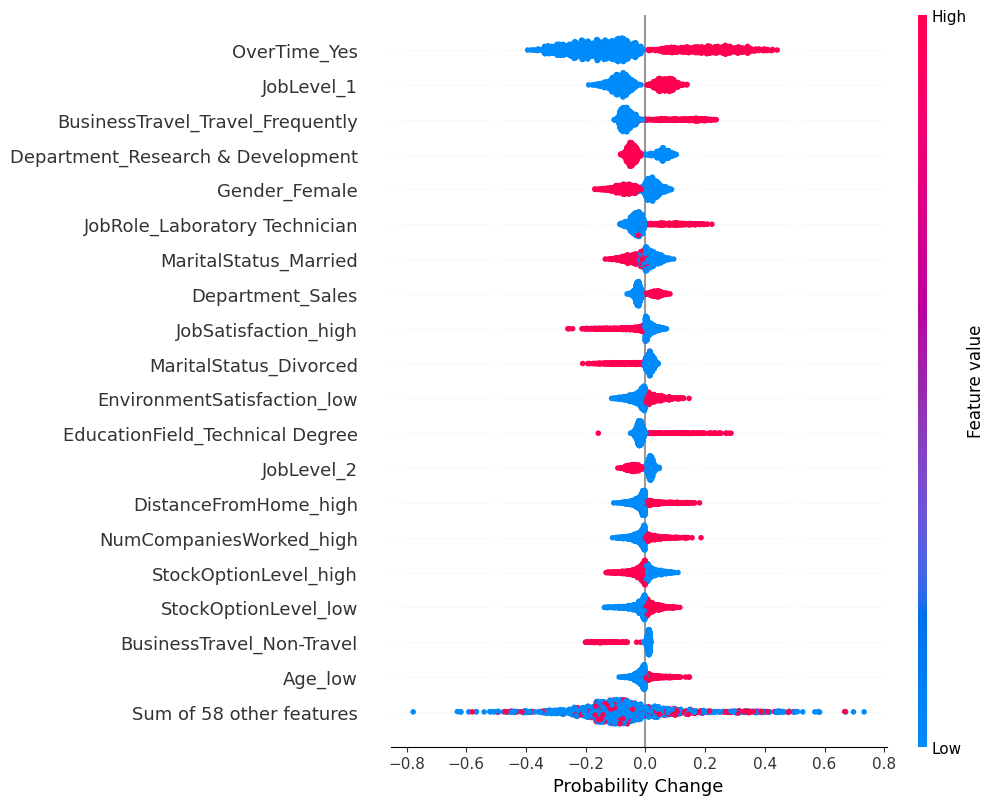

In [58]:
def get_shap_values_prob(model, df, target_col='Attrition'):
    import shap

    X = df.drop(columns=[target_col])
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    
    # Convert SHAP values to probability contributions for all samples
    prob_contributions_matrix = convert_shap_to_prob_contributions(shap_values)
    
    # Create explanation object with probability contributions
    prob_shap_values = shap.Explanation(
        values=prob_contributions_matrix,
        base_values=np.array([logit_to_prob(base_val) for base_val in shap_values.base_values]),
        data=shap_values.data,
        feature_names=shap_values.feature_names
    )
    
    shap.plots.beeswarm(prob_shap_values, max_display=20, show=False)
    plt.xlabel('Probability Change')
    plt.show()
    
    return prob_shap_values

prob_shap_values = get_shap_values_prob(imbalanced_model, df_bool)

In [22]:
pd.DataFrame(shap_values[0].values)

,0
0,0.032319
1,-0.312096
2,0.021608
3,-0.003590
4,0.313696
...,...
72,-0.197940
73,-0.120882
74,-0.013172
75,0.006235
